<a href="https://colab.research.google.com/github/nprime496/building-floor-recognition/blob/main/code/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sortie de u-net avec plusieurs channels

## setup

In [52]:
!nvidia-smi

Wed Jul  6 14:32:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.11.0+cu113
0.11.0+cu113


In [54]:
import random 
import os

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
from IPython.display import Audio, display

In [57]:
import librosa


In [58]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [59]:
def seed_all(SEED_VAL=1):
        random.seed(SEED_VAL)
        np.random.seed(SEED_VAL)
        torchaudio.utils.sox_utils.set_seed(SEED_VAL)
        torch.manual_seed(SEED_VAL)
        torch.cuda.manual_seed_all(SEED_VAL)
        os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [60]:
seed_all(496)

## utils

In [61]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


In [62]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


In [63]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


In [64]:

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


In [65]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


## Data 

In [ ]:
# # Unzip dataset
# !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
# !tar -xzf urban8k.tgz
# !rm urban8k.tgz

In [ ]:
!cat UrbanSound8K/UrbanSound8K_README.txt

In [ ]:
from torch.utils.data import Dataset

In [ ]:
# sample wav for testing purposes
SAMPLE_WAV_PATH="file_example_WAV_1MG.wav"

In [ ]:
metadata = torchaudio.info(SAMPLE_WAV_PATH,format="wav")
print(metadata)

In [ ]:
waveform,sample_rate = torchaudio.load(SAMPLE_WAV_PATH,format="wav")


In [ ]:
print_stats(waveform,sample_rate)

In [ ]:
play_audio(waveform,sample_rate)

## Preprocessing

In [ ]:
plot_waveform(waveform,sample_rate=sample_rate)

In [ ]:
# spectrogram showcase repartition of frequencies in the sample
plot_specgram(waveform,sample_rate)

Shape: (2, 513, 524)
Dtype: torch.float32
 - Max:     8004.559
 - Min:      0.000
 - Mean:     8.675
 - Std Dev: 108.616

tensor([[[3.3975e-03, 1.1418e-05, 1.4600e-06,  ..., 3.5515e+00,
          1.6623e+00, 2.5219e-02],
         [4.0124e-03, 1.9830e-05, 1.7702e-06,  ..., 2.4813e+01,
          2.1629e+00, 1.0710e-01],
         [4.7727e-03, 8.8398e-05, 2.0874e-04,  ..., 4.5257e+01,
          3.3142e+00, 1.8119e-01],
         ...,
         [1.7693e-05, 6.9392e-06, 4.4464e-07,  ..., 3.4267e-05,
          1.8854e-05, 6.5531e-06],
         [8.6515e-06, 1.1906e-05, 5.6316e-06,  ..., 6.1409e-06,
          4.5327e-06, 9.6336e-06],
         [8.5089e-07, 8.0468e-06, 8.4641e-06,  ..., 7.1103e-07,
          6.9376e-06, 1.1192e-05]],

        [[9.8497e-04, 1.5866e-05, 1.2531e-06,  ..., 5.3155e+00,
          4.0004e-01, 5.0080e-02],
         [1.1827e-03, 2.3545e-05, 1.7976e-05,  ..., 2.4263e+01,
          2.9311e+00, 1.0008e+00],
         [1.7116e-03, 1.4517e-04, 5.3488e-05,  ..., 2.4378e+01,
      

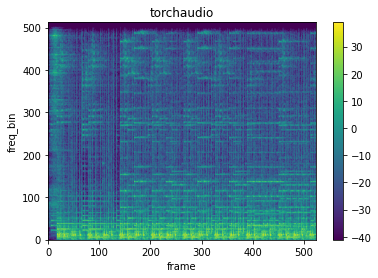

In [76]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

Shape: (2, 256, 524)
Dtype: torch.float32
 - Max:     203.173
 - Min:     -354.231
 - Mean:     0.394
 - Std Dev: 12.263

tensor([[[-2.8392e+02, -2.5898e+02, -2.3179e+02,  ...,  1.0897e+02,
           2.2764e+01, -4.1402e+01],
         [-4.2393e+00, -1.1460e+01, -3.2111e+01,  ...,  1.0317e+02,
           1.0038e+02,  1.0252e+02],
         [-5.6729e+01, -5.3581e+01, -4.6562e+01,  ...,  2.9147e+01,
           4.4467e+01,  2.8765e+01],
         ...,
         [ 1.2738e+00,  1.1109e+00,  2.2440e+00,  ...,  7.9137e-02,
           1.4939e+00,  1.1803e-01],
         [ 1.6561e+00, -3.0897e+00, -4.4600e+00,  ...,  9.2210e-01,
           2.3270e+00,  5.4714e-01],
         [ 2.3831e+00, -1.2931e+00, -1.7394e+00,  ..., -8.5079e-01,
          -1.9468e+00, -8.0475e-01]],

        [[-3.5423e+02, -3.3511e+02, -3.1073e+02,  ...,  1.0423e+02,
           8.8950e+00, -8.2387e+01],
         [-7.4758e+00, -2.2721e+01, -4.4517e+01,  ...,  1.0188e+02,
           1.0252e+02,  1.1808e+02],
         [-4.0352e+01,

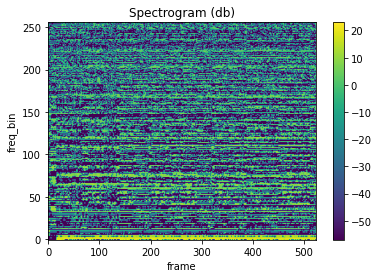

In [77]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

In [78]:
from torchaudio.transforms import MFCC

In [79]:
def clean_mfcc(data):
  pass

def clean_spectrogram(data):
  pass

## Dataset

In [80]:
# For testing purposes
class UrbanSoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList):
        csvData = pd.read_csv(csv_path)
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
         #self.mixer = torchaudio.transforms.DownmixMono() 
        self.folderList = folderList
        
    def __getitem__(self, index):
        #format the file path and load the file
        path = self.file_path + "fold" + str(self.folders[index]) + "/" + self.file_names[index]
        sound = torchaudio.load(path, normalize = True)
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)

        soundData = torch.mean(sound[0], dim=0).unsqueeze(0) # #UrbanSound8K uses two channels, this will convert them to one
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[:].T
        else:
            tempData[:] = soundData[:,:160000].T
        
        soundData = tempData
        soundFormatted = torch.zeros([32000, 1])
        soundFormatted[:32000] = soundData[::5] #take every fifth sample of soundData
        soundFormatted = soundFormatted.permute(1, 0)
        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)


In [81]:
csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
file_path = './UrbanSound8K/audio/'

train_set = UrbanSoundDataset(csv_path, file_path, range(1,10))
test_set = UrbanSoundDataset(csv_path, file_path, [10])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {} #needed for using datasets on gpu

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, **kwargs)

Train set size: 7895
Test set size: 837


In [82]:
train_set[2451][0].shape

torch.Size([1, 32000])

In [83]:
class MFCCDataset(Dataset):
  def __init__(self):
    pass

  def __getitem__(self,idx):
    pass

  def __len__(self):
    pass

In [84]:
class RawDataset(Dataset):
  def __init__(self):
    pass

  def __getitem__(self,idx):
    pass

  def __len__(self):
    pass

In [85]:
class SpectrogramDataset(Dataset):
  def __init__(self):
    pass

  def __getitem__(self,idx):
    pass

  def __len__(self):
    pass

## Models

In [86]:
from torch import nn

In [87]:
class SimpleNet(nn.Module):
    def __init__(self,in_channels=1,n_output=3):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv1d(in_channels, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        
            nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv1d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
            
            nn.Conv1d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv1d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(256,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),

            nn.Conv1d(128,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool1d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32000,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,n_output)
        )
    
    def forward(self, xb):
        emb = self.network(xb)
        return self.classifier(emb)


In [88]:
# net=SimpleNet()

In [89]:
# train_set[0][0].unsqueeze(0).shape

In [90]:
# conv= nn.Conv1d(1, out_channels = 32, kernel_size = 3, padding = 1)

In [91]:
4000*256

1024000

In [92]:
# net(train_set[0][0].unsqueeze(0))

In [93]:
class MFCCClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [94]:
class Rawlassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [95]:
class SpectrogramClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    pass

  def __forward(self,X):
    pass

In [96]:
class LateFusionClassifier(nn.Module):
  # Model used in late fusion classification
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

In [97]:
class EarlyFusionClassifier(nn.Module):
  def __init__(self,estimators,ensemble_model):
    super().__init__()
    self._estimators = [est.copy() for est in estimators]
    self._ensemble = ensemble_model
    pass
  def forward(self,X):
    for i,est in enumerate(self._estimators):
      self._estimators.eval()
      est.forward(X[i]) # concat les resultats
    self._ensemble.forward(X)
  

## Training

### utils

In [104]:
from torch.autograd import Variable

# Function to save the model
def saveModel(model,path = "./myFirstModel.pth"):
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model,test_loader,loss_fn):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(loss,accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model,train_loader,optimizer,loss_fn,eval_loader=None,num_epochs = 10,train_steps=1000,eval_steps=1000,device=torch.device("cpu")):
    
    best_accuracy = 0.0


    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % (train_steps) == (train_steps-1):    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / train_steps))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        eval_loss, accuracy = testAccuracy(model,eval_loader)
        print('Epoch[', epoch+1,'] eval accuracy %d %%' % (accuracy),"eval loss %d %%" % (eval_loss))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel(model)
            best_accuracy = accuracy

### Actual training

In [105]:
net = SimpleNet(in_channels=1,n_output=10)
rate_learning = 3e-4

In [106]:
net

SimpleNet(
  (network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): ReLU()
    (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): ReLU()
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): ReLU()
    (14): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): ReLU()
    (17): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (18): Conv1d(

In [107]:

model = net
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Approximated model size: {:.3f}MB'.format(size_all_mb))

Approximated model size: 128.881MB


In [108]:
optimizer = torch.optim.Adam(net.parameters(), lr=rate_learning)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train(net,train_loader,optimizer,loss_fn,eval_loader=test_loader,num_epochs = 2,train_steps=10,device=device)

The model will be running on cuda:0 device
[1,    10] loss: 2.300
[1,    20] loss: 2.273
[1,    30] loss: 2.271
[1,    40] loss: 2.274
[1,    50] loss: 2.268
[1,    60] loss: 2.264
[1,    70] loss: 2.270
[1,    80] loss: 2.257
[1,    90] loss: 2.273
[1,   100] loss: 2.271
[1,   110] loss: 2.275
[1,   120] loss: 2.265
[1,   130] loss: 2.276
[1,   140] loss: 2.252
[1,   150] loss: 2.250
[1,   160] loss: 2.257
[1,   170] loss: 2.276
[1,   180] loss: 2.262
[1,   190] loss: 2.269
